In [1]:
import pandas as pd
import numpy as np
import torch
import torchsde
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import optuna
import matplotlib.pyplot as plt


dataset_path = r"..\..\datasets\btc_options_data\european_btc_calls.csv"

# MAPE 
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(true, predicted, model_name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    mape = mean_absolute_percentage_error(true, predicted)
    r2 = r2_score(true, predicted)
    print(f"\nPerformance {model}:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f" MAPE: {mape}%")


european_calls = pd.read_csv(dataset_path)

# Just being Lazy
def evaluate_nn(true, predicted):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    percent_error = np.abs((true - predicted) / true) * 100
    pe5 = np.mean(percent_error <= 5) * 100  # Percentage of predictions within 5% error
    pe10 = np.mean(percent_error <= 10) * 100  # Percentage of predictions within 10% error
    pe20 = np.mean(percent_error <= 20) * 100  # Percentage of predictions within 20% error

    
    print(f"\n Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  PE5: {pe5:.2f}%")
    print(f"  PE10: {pe10:.2f}%")
    print(f"  PE20: {pe20:.2f}%")



In [2]:
# As seen in the Brazilian Options Data, it is crucial to separate the options by Moneyness.
def classify_moneyness(row):
    if row['MONEYNESS'] > 1.05:  # ITM: S/K > 1.05
        return 'ITM'
    elif 0.95 <= row['MONEYNESS'] <= 1.05:  # ATM: 0.95 <= S/K <= 1.05
        return 'ATM'
    else:  # OTM: S/K < 0.95
        return 'OTM'

european_calls['MONEYNESS_CATEGORY'] = european_calls.apply(classify_moneyness, axis=1)

# Because we have concentrations of data on very different premium values, we use stratified shuffle split
# Again, I splitted it with the Moneyness Category in mind
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(european_calls, european_calls['MONEYNESS_CATEGORY']):
    train_data = european_calls.iloc[train_idx]
    test_data = european_calls.iloc[test_idx]

# Our data does not have a Risk Free Rate column, which is essential for Black-Scholes calculation;
# Since we are solving the same problem B-S solves, I chose to include in it
risk_free_rate = 0.0431  # https://www.cnbc.com/quotes/US1Y
train_data['RISK_FREE_RATE'] = risk_free_rate
test_data['RISK_FREE_RATE'] = risk_free_rate

# Handle outliers in NEGOTIATED_PRICE
price_upper_limit = train_data['NEGOTIATED_PRICE'].quantile(0.99)
price_lower_limit = train_data['NEGOTIATED_PRICE'].quantile(0.01)
train_data['NEGOTIATED_PRICE'] = train_data['NEGOTIATED_PRICE'].clip(lower=price_lower_limit, upper=price_upper_limit)

# A few other metrics that might be useful, as they come up a lot in Options Theory
train_data['INTRINSIC_VALUE'] = np.maximum(train_data['UNDERLYING_PRICE'] - train_data['STRIKE'], 0)
test_data['INTRINSIC_VALUE'] = np.maximum(test_data['UNDERLYING_PRICE'] - test_data['STRIKE'], 0)

train_data['RELATIVE_IV'] = train_data['MARK_IV'] / train_data['MONEYNESS']
test_data['RELATIVE_IV'] = test_data['MARK_IV'] / test_data['MONEYNESS']

# Attention: these features are not the original ones. These are the result of analysing correlations to prevent
# issues such as multicollinearity.
features = [
    "UNDERLYING_PRICE",
    "DTE",
    "MARK_IV",
    "MONEYNESS",
    "DELTA",
    "THETA",
]

target = 'NEGOTIATED_PRICE'

# Drop MONEYNESS_CATEGORY (it is a String)
train_data = train_data.drop(columns=['MONEYNESS_CATEGORY'])
test_data = test_data.drop(columns=['MONEYNESS_CATEGORY'])

# Scale with RobustScaler;
# Similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.
# https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler
scaler = RobustScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data[target].values
y_test = test_data[target].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26372\4268892853.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26372\4268892853.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26372\4268892853.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [3]:
# ------------------------- Neural SDE Model ------------------------- #
class TunableNeuralSDE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(TunableNeuralSDE, self).__init__()
        self.activation = activation
        self.f = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, output_dim)
        )
        self.g = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, x):
        drift = self.f(x)
        diffusion = self.g(x)
        return drift, diffusion

# ------------------------- Hyperparameter Tuning ------------------------- #
# Hyperparameter space
#hidden_dims = [64, 128, 256]
#activations = [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
#learning_rates = [0.001, 0.0005, 0.0001]
#batch_sizes = [32, 64, 128]

#best_mse = float('inf')
#best_params = None

#for hidden_dim, activation, lr, batch_size in itertools.product(hidden_dims, activations, learning_rates, batch_sizes):
    # Initialize model
    #model = TunableNeuralSDE(input_dim=len(features), hidden_dim=hidden_dim, output_dim=1, activation=activation)
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    #loss_fn = nn.MSELoss()

    #for epoch in range(10): 
        #model.train()
        #perm = torch.randperm(X_train_tensor.size(0))
        #for i in range(0, X_train_tensor.size(0), batch_size):
            #idx = perm[i:i + batch_size]
            #X_batch = X_train_tensor[idx]
            #y_batch = y_train_tensor[idx]

            #optimizer.zero_grad()
            #drift, diffusion = model(0, X_batch)
            #loss = loss_fn(drift.squeeze(), y_batch)
            #loss.backward()
            #optimizer.step()

    #model.eval()
    #with torch.no_grad():
        #drift_test, _ = model(0, X_test_tensor)
        #mse = loss_fn(drift_test.squeeze(), y_test_tensor).item()

    # Best config
    #if mse < best_mse:
        #best_mse = mse
        #best_params = {
            #'hidden_dim': hidden_dim,
            #'activation': activation,
            #'learning_rate': lr,
            #'batch_size': batch_size,
            #'mse': mse
        #}

    #print(f"Test MSE: {mse:.4f}, Params: {hidden_dim}, {activation}, {lr}, {batch_size}")

#print("\nBest Hyperparameters:")
#for param, value in best_params.items():
    #print(f"{param}: {value}")

In [4]:

best_model = TunableNeuralSDE(
    input_dim=len(features),
    hidden_dim=256,  # Best hidden_dim
    output_dim=1,
    activation=nn.ELU(alpha=1.0)  # Best activation
)

optimizer = optim.Adam(best_model.parameters(), lr=0.001)  # Best learning rate
loss_fn = nn.MSELoss()

# Training setup
n_epochs = 50  # Train for more epochs now
batch_size = 32  # Best batch size
learning_rate_history = []

# Training loop
for epoch in range(n_epochs):
    best_model.train()
    perm = torch.randperm(X_train_tensor.size(0))
    batch_loss = 0

    for i in range(0, X_train_tensor.size(0), batch_size):
        idx = perm[i:i + batch_size]
        X_batch = X_train_tensor[idx]
        y_batch = y_train_tensor[idx]

        optimizer.zero_grad()
        drift, diffusion = best_model(0, X_batch)
        loss = loss_fn(drift.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
    epoch_loss = batch_loss / (X_train_tensor.size(0) // batch_size)
    learning_rate_history.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {batch_loss / (X_train_tensor.size(0) // batch_size):.4f}")



Epoch 1/50, Loss: 122965283.1288
Epoch 2/50, Loss: 11023032.1453
Epoch 3/50, Loss: 6855547.4737
Epoch 4/50, Loss: 5231095.9835
Epoch 5/50, Loss: 4011076.3177
Epoch 6/50, Loss: 3052283.9825
Epoch 7/50, Loss: 2326411.9016
Epoch 8/50, Loss: 1814642.2198
Epoch 9/50, Loss: 1469182.5906
Epoch 10/50, Loss: 1197442.9293
Epoch 11/50, Loss: 1038610.0353
Epoch 12/50, Loss: 892564.1099
Epoch 13/50, Loss: 789965.2065
Epoch 14/50, Loss: 720832.1758
Epoch 15/50, Loss: 655192.0726
Epoch 16/50, Loss: 612003.0627
Epoch 17/50, Loss: 579156.5666
Epoch 18/50, Loss: 541612.9205
Epoch 19/50, Loss: 514654.0426
Epoch 20/50, Loss: 497508.1637
Epoch 21/50, Loss: 482143.1976
Epoch 22/50, Loss: 461543.6488
Epoch 23/50, Loss: 444513.4255
Epoch 24/50, Loss: 442184.1227
Epoch 25/50, Loss: 422810.5808
Epoch 26/50, Loss: 414800.7809
Epoch 27/50, Loss: 404616.4212
Epoch 28/50, Loss: 395545.1157
Epoch 29/50, Loss: 393649.9411
Epoch 30/50, Loss: 389743.5777
Epoch 31/50, Loss: 386517.3859
Epoch 32/50, Loss: 381201.0238
Epo

In [5]:
best_model.eval()
with torch.no_grad():
    y_test_np = y_test_tensor.numpy()
    drift_test, _ = best_model(0, X_test_tensor)
    predictions = drift_test.squeeze().numpy()

    metrics = evaluate_nn(y_test_np, predictions)
    print(metrics)



 Performance:
  MSE: 461847.125
  MAE: 226.0142822265625
  R^2: 0.9961415054410104
  PE5: 55.95%
  PE10: 67.05%
  PE20: 77.08%
None


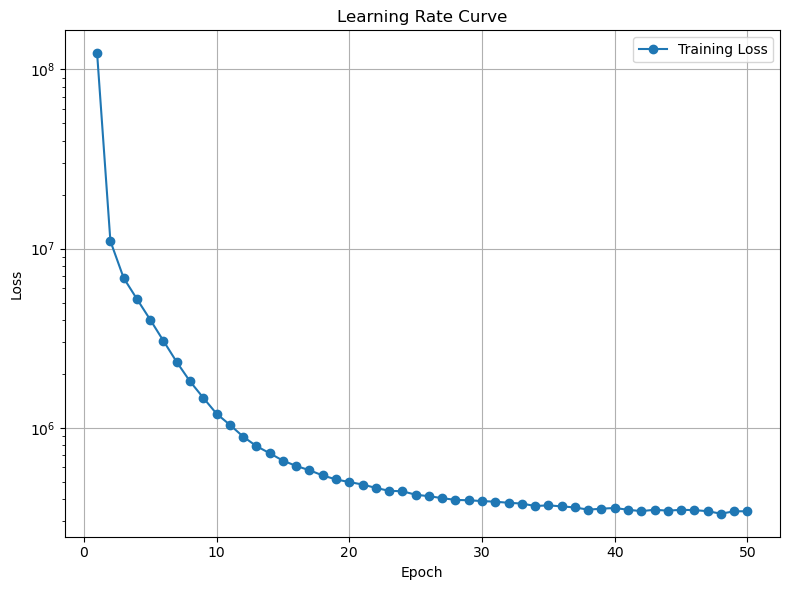

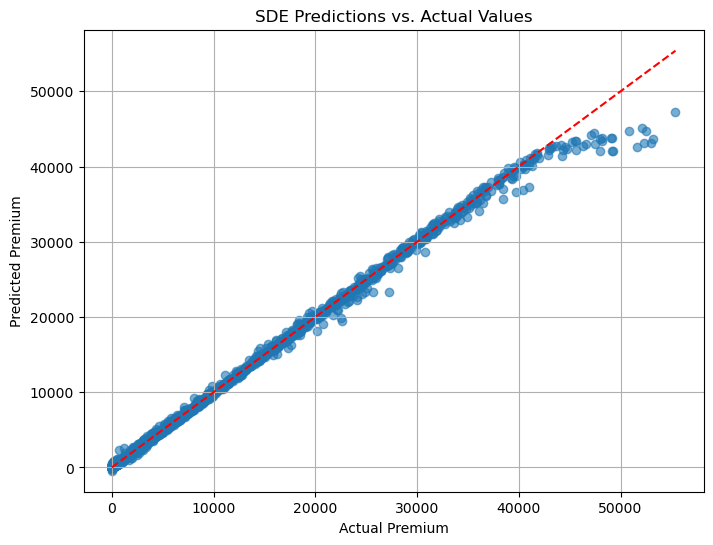

In [6]:
# loss reduction over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_epochs + 1), learning_rate_history, marker='o', label="Training Loss")
plt.title("Learning Rate Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, drift_test.squeeze().numpy(), alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Premium")
plt.ylabel("Predicted Premium")
plt.title("SDE Predictions vs. Actual Values")
plt.grid()
plt.show()


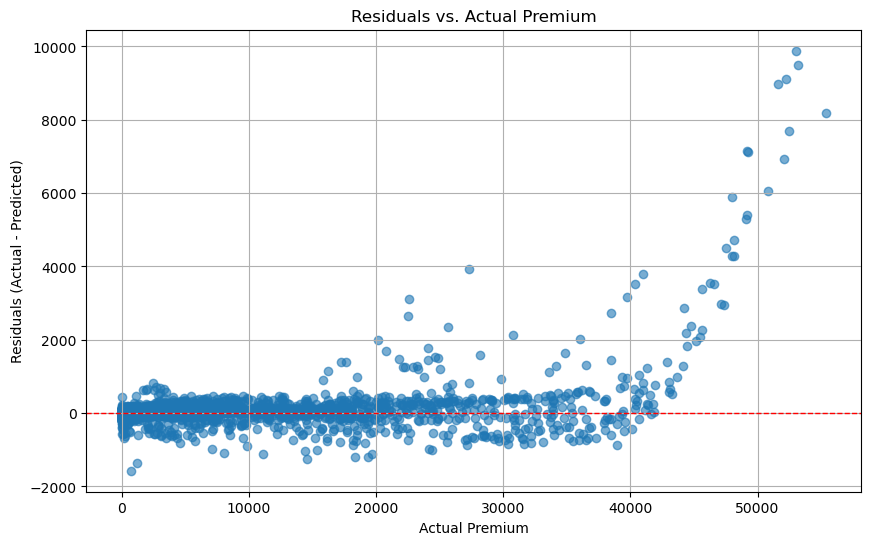

In [7]:
actual_values = y_test  
predicted_values = drift_test.squeeze().numpy() 

residuals = actual_values - predicted_values

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs. Actual Premium")
plt.xlabel("Actual Premium")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid()
plt.show()

In [8]:
# Segmented Modeling: Separate the data based on MONEYNESS (ITM, ATM, OTM)
# For Brazilian Options Data, separating the options by Moneyness is crucial for better modeling.
# Thus, I think trying here would be cool.
# We have to put Moneyness again
def classify_moneyness(row):
    if row['MONEYNESS'] > 1.05:  # ITM: S/K > 1.05
        return 'ITM'
    elif 0.95 <= row['MONEYNESS'] <= 1.05:  # ATM: 0.95 <= S/K <= 1.05
        return 'ATM'
    else:  # OTM: S/K < 0.95
        return 'OTM'
    
# Categorize MONEYNESS for each dataset
train_data['MONEYNESS_CATEGORY'] = train_data.apply(classify_moneyness, axis=1)
test_data['MONEYNESS_CATEGORY'] = test_data.apply(classify_moneyness, axis=1)

# Split training data into ITM, ATM, and OTM segments
train_ITM = train_data[train_data['MONEYNESS_CATEGORY'] == 'ITM']
train_ATM = train_data[train_data['MONEYNESS_CATEGORY'] == 'ATM']
train_OTM = train_data[train_data['MONEYNESS_CATEGORY'] == 'OTM']

# Split test data into ITM, ATM, and OTM segments
test_ITM = test_data[test_data['MONEYNESS_CATEGORY'] == 'ITM']
test_ATM = test_data[test_data['MONEYNESS_CATEGORY'] == 'ATM']
test_OTM = test_data[test_data['MONEYNESS_CATEGORY'] == 'OTM']

# Initialize a dictionary to store models for each segment
segment_models = {}
segments = {
    'ITM': (train_ITM, test_ITM),
    'ATM': (train_ATM, test_ATM),
    'OTM': (train_OTM, test_OTM)
}

# Train separate Tunable Neural SDE models for each segment
for segment, (train_segment, test_segment) in segments.items():
    X_train_segment = train_segment[features].values
    y_train_segment = train_segment[target].values
    X_test_segment = test_segment[features].values
    y_test_segment = test_segment[target].values

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train_segment, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_segment, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_segment, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_segment, dtype=torch.float32)

    # Train a Tunable Neural SDE model
    model = TunableNeuralSDE(
        input_dim=len(features),
        hidden_dim=256,  # Segment-specific best parameters could be tuned here
        output_dim=1,
        activation=nn.ELU(alpha=1.0)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(100):  # Fixed epochs for all segments
        model.train()
        optimizer.zero_grad()
        drift, _ = model(0, X_train_tensor)
        loss = loss_fn(drift.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate and store the model
    model.eval()
    with torch.no_grad():
        drift_test, _ = model(0, X_test_tensor)
        predictions = drift_test.squeeze().numpy()

    metrics = evaluate_nn(y_test_segment, predictions)
    
    segment_models[segment] = {
        'model': model,
        'test_data': (X_test_segment, y_test_segment),
        'predictions': predictions
    }
        
# Order of output: ITM, ATM, OTM|


 Performance:
  MSE: 130606582.0867416
  MAE: 9271.442514847568
  R^2: 0.013751103158953448
  PE5: 5.98%
  PE10: 10.94%
  PE20: 21.99%

 Performance:
  MSE: 8255032.219691371
  MAE: 2212.6975146156137
  R^2: 0.019842257781514383
  PE5: 2.70%
  PE10: 8.09%
  PE20: 14.83%

 Performance:
  MSE: 4474174.736436616
  MAE: 1470.8489759582703
  R^2: 0.020787329496638418
  PE5: 1.19%
  PE10: 2.46%
  PE20: 6.44%


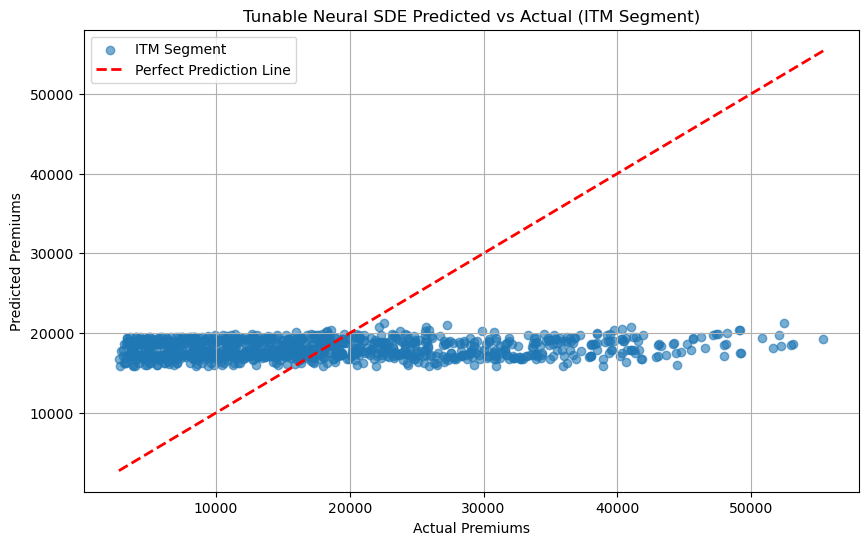

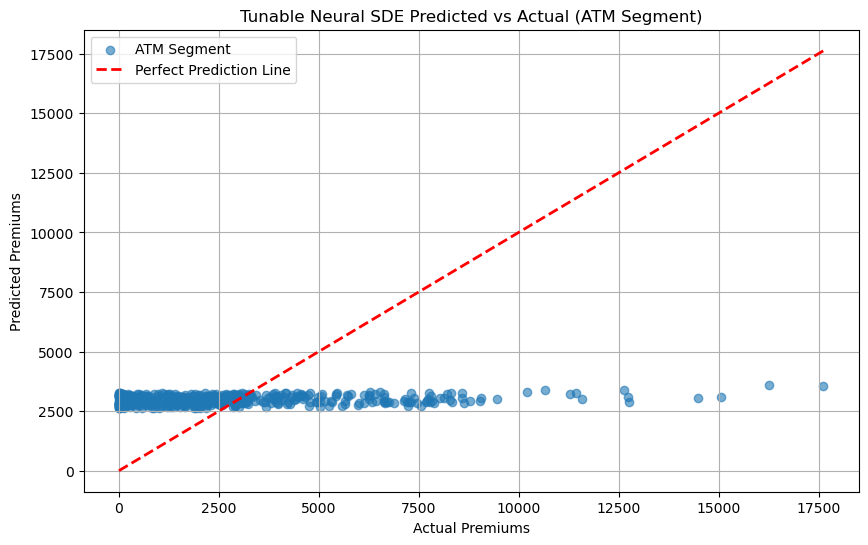

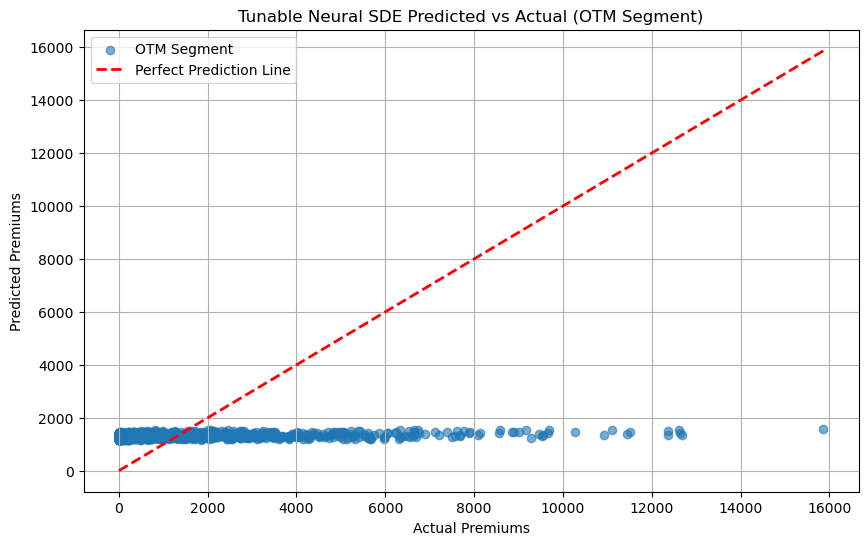

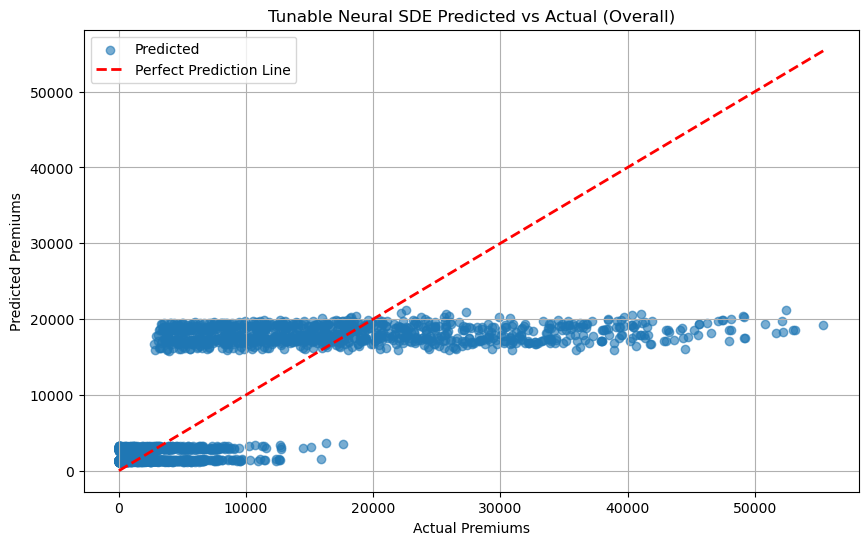

In [9]:
# Predicted vs Actual for each segment
for segment in segments.keys():
    y_test = segment_models[segment]['test_data'][1]  # Actual y_test
    predictions = segment_models[segment]['predictions']  # Predicted values

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.6, label=f'{segment} Segment')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
    plt.title(f"Tunable Neural SDE Predicted vs Actual ({segment} Segment)")
    plt.xlabel("Actual Premiums")
    plt.ylabel("Predicted Premiums")
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine data for overall comparison
y_test_overall = np.concatenate([segment_models[segment]['test_data'][1] for segment in segments.keys()])
predictions_overall = np.concatenate([segment_models[segment]['predictions'] for segment in segments.keys()])

# Overall dataset visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test_overall, predictions_overall, alpha=0.6, label="Predicted")
plt.plot([y_test_overall.min(), y_test_overall.max()], [y_test_overall.min(), y_test_overall.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
plt.title("Tunable Neural SDE Predicted vs Actual (Overall)")
plt.xlabel("Actual Premiums")
plt.ylabel("Predicted Premiums")
plt.legend()
plt.grid(True)
plt.show()
